In [1]:
# import python libraries dependencies and set up the backend
import numpy as np
import time
import progressbar
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import exact_diagonalisation.ed_ising as ED 

tabcols = list(mcolors.TABLEAU_COLORS)

# Time Evolution

Assumes an L x W lattice of sites and uses lists length L x W to specify hx for each site and a matrix J (LW x LW) specified for the couplings. Evolves under Hamiltonian
\begin{equation}\label{eq:}
H = -\sum_{i, j>i} J_{ij} \sigma_z^i\sigma_z^j - \sum_{i}hx_i \sigma_x^i
\end{equation}

Generates random initial state L x W in the z basis. An initial state in the X basis can be used instead by specifying the xinit and xmeas parameters. nnonly parameter should be set to true if only nearest neighbour coupling is present

In [36]:
# define system parameters
xinit = False
xmeas = False
nnonly = True
parallel = True
p = {}
p['L'] = L = 3 # system length
p['W'] = W  = 2 # system width
p['N'] = N = p['L'] * p['W'] # number of system in the system
p['hx'] = hx = np.array([.5 + np.random.random() for _ in range(L * W)]) # transverse Ising field for each site 
p['hz'] = hz = np.array([0. for _ in range(L * W)]) # longitudinal Ising field for each site 

J_val = 1.
if nnonly:
    J = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            s_r, s_c = i // W, i % W
            t_r, t_c = j // W, j % W
            h_dist = abs(s_r - t_r)
            v_dist = abs(s_c - t_c)
            dist = np.sqrt(h_dist**2 + v_dist** 2)
            if dist == 1:
                J[i][j] = J_val
    p['J'] = J
    J = J_val
else:
    J = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            s_r, s_c = i // W, i % W
            t_r, t_c = j // W, j % W
            h_dist = abs(s_r - t_r)
            v_dist = abs(s_c - t_c)
            dist = np.sqrt(h_dist**2 + v_dist** 2)
            if dist > 0:
                J[i][j] = J_val / dist**2
    J = J.tolist()
    p['J'] = J
p['t_initial'] = 0 # begin of time evolution
p['dt'] = dt = 0.01 # time-step
p['t_final'] = total_time = 1.0 # end of time evolution
times = np.linspace(0, total_time, num=11)
ave = 500 # measurement count for qsharp meas
initial_state = [random.getrandbits(1) for _ in range(N)]
state_table = ED.generate_state_table(p)
basis = 'X' if xmeas else 'Z'

In [37]:
# import Q# library (based on whether or not nearest neighbour)
import qsharp
from qsharp import Result
if nnonly:
    from Quantum.Isingnearest import Evolve, EvolveSingleTimestepDummy
else:
    from Quantum.Isinglongrange import Evolve, EvolveSingleTimestepDummy

In [38]:
# do exact evolution
tic = time.time()
sim, state_table = ED.evolve(p, state_table, initial_state, kind="list", trotterised=True, xinit=xinit)
toc = time.time()
print("Exact evolution took ", toc-tic, "s")

Exact evolution took  0.16480779647827148 s


In [39]:
# do qsharp evolution
tic = time.time()
result = np.zeros((len(times), N))
progress_bar = progressbar.ProgressBar(max_value=ave)
points_taken = 0
for _ in range(ave):
    for i, t in enumerate(times):
        res = Evolve.simulate(
                initialState=initial_state, time=t, dt=dt, g=list(hx), h=list(hz), J=J,
                parallel=parallel, xinit=xinit, xmeas=xmeas)
        result[i] += np.array(res) / ave
    points_taken += 1
    progress_bar.update(points_taken)
toc = time.time()
print("Q# Evolution took {} mins {} s".format(int((toc-tic) // 60), int((toc-tic) % 60)))

100% (500 of 500) |######################| Elapsed Time: 0:11:20 ETA:  00:00:00

Q# Evolution took 11 mins 21 s


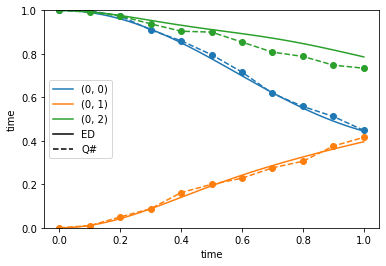

In [40]:
# plot
fig = plt.figure()
qubits = [(0, 0), (0, 1), (0, 2)]
for i, q in enumerate(qubits):
    site_res = 1 - (sim['{}i Site {}'.format(basis, i)] + 1) / 2
    plt.plot(sim['Time'], site_res, label='{}'.format(q), marker='', linestyle='-', color=tabcols[i])
    plt.plot(times, result[:, i], color=tabcols[i], marker='o', linestyle='--')
plt.ylim(0, 1)  
handles, labels = fig.axes[0].get_legend_handles_labels()
handles = list(handles) + [plt.Line2D((0, 1), (0, 0), color='k', linestyle='-'),
                           plt.Line2D((0, 1), (0, 0), color='k',linestyle='--')]
labels = list(labels) + ['ED', 'Q#']
plt.xlabel('time')
plt.ylabel('time')
plt.legend(handles, labels)

# Resource Estimation

Estimate the resources for the full evolution (1st order) and for a single timestep. Currently the depth only measures T gates of which there are none.

In [42]:
# estimate resources
full_gatecount = Evolve.estimate_resources(
                    initialState=initial_state, time=t, dt=dt, g=list(hx), h=list(hz), J=J,
                    parallel=parallel, xinit=xinit, xmeas=xmeas)
timestep_gatecount = EvolveSingleTimestepDummy.estimate_resources(
                        nSites=len(initial_state), dt=dt, g=list(hx), h=list(hz), J=J,
                        parallel=parallel, xinit=xinit, xmeas=xmeas)

print('Full Evolution')
print(*['\t{}: {}\n'.format(k, v) for k, v in full_gatecount.items()])
print('Single Timestep')
print(*['\t{}: {}\n'.format(k, v) for k, v in timestep_gatecount.items()])

Full Evolution
	CNOT: 800
 	QubitClifford: 4
 	R: 1600
 	Measure: 6
 	T: 0
 	Depth: 0
 	Width: 6
 	BorrowedWidth: 0

Single Timestep
	CNOT: 8
 	QubitClifford: 0
 	R: 16
 	Measure: 0
 	T: 0
 	Depth: 0
 	Width: 6
 	BorrowedWidth: 0

